**05 - PyTorch Custom Datasets**

Previously, we looked into building computer vision models with data that was already built into PyTorch such as *FashionMNIST* and *MNIST* datasets. At the same time we also explored a new type of architecture - convolutional neural networks.

The steps that we used to solve these many different problems with these datasets are usually similiar across the board. That's how it is in machine learning. 

We find and pick a dataset to work with, tranform these datasets into numbers, then build a model (or pick an already existing model) to find patterns in these numbers, use these patterns to predict something.

PyTorch has plenty of built-in datasets that can be used for a large range of machine learning benchmarks and there are even plenty more ready-to-use datasets that are assembled by other people. 

However, what if you want to use your own **custom dataset?**

**What is a custom dataset?**

Before we start going deep into things, let's ask the very simple question of what is a custom dataset? 

It's just a collection of data relating to a specific problem that you are trying to solve. So technically speaking, a custom dataset can contain almost anything.

For example, if we want to work with an app that can recognize the faces of your friends and family members then our custom dataset can be contain pictures of their faces. 

We're not even limited to just images. Say we want to recognize if a text-based review left by a customer is positive or negative about a certain restaurant. Our custom dataset might be a series of reviews left by customers and their associated ratings. 

If we want want to recognize a certain instruments then our dataset might contain audio samples of those instruments alongside their labels. 

We can go so far as to make a recommendation system for customers that want to purchase items. Our custom dataset might be products that other people have bought that are similiar to our customer's purchase history. 

![Display](images/04-pytorch-domain-libraries.png "Domain Libraries")

PyTorch contains many different functions that can load different custom datasets. We've already used *TorchVision* before but that is just one of many. There are the following: *TorchVision*, *TorchAudio*, *TorchText*, and *TorchRec* domain libraries.

But even with these many different domains that can accomodate for a wide range of cases, it still doesn't cover everything. In the case that PyTorch doesn't have what you need then you have the option to subclass *torch.utils.data.Dataset* and from there start customizing.

**Coverage of Lesson**

The coverage retains many of the work that we've done in the previous chapters. We'll be implementing the same workflow as before to a computer vision problem.

However, the only difference is that as compared to using a built-in PyTorch dataset, we're going to work with our own personal custom dataset of pizza, steak, and sushi images.

The end goal for this chapter is that we would be able to load these images and then use a mode to train and then predict on these data. 

![Display](images/04-pytorch-food-vision-layout.png "Chapter Layout")

Let's break this down chapter further:

1. **Importing PyTorch + Setting up device-agnostic code** : We'll be loading in Pytorch and follow the best practices to create device-agnostic code.

2. **Get Data** : We'll be grabbing our own custom dataset for pizza, steak, and sushi images.

3. **Data Preperation** : The first thing that must be done before starting anything with machine learning is by understanding the data that we are working with. It is vital that the data is understood and detailed before anything must be done to process it.

4. **Transforming Data** : For the most part, just grabbing data randomly off the internet won't instantly be usable. There are steps that must first be taken to transform the data so that models can actually start using them.

5. **Loading Data Using ImageFolder - Option 1** : PyTorch has many different types of built-in loading functions that can be used for common data types. *ImageFolder* is one such function that is helpful for images that are in a standard image classification format.

6. **Loading Image Data with Custom Dataset** : Let's assume that PyTorch doesn't have a built-in function that can load data. What are we going to do? Well, we can still create our custom data set by subclassing *torch.utils.data.Dataset*

7. **Other Forms of Transforming Data -  Data Augmentation** : Data augmentation is a means of expanding data diversity. That means the data would be scaled, rotated, tilted, etc. We'll be exploring *torchvision*'s built-in data augmentation functions.

8. **Model 0: TinyVGG w/o Data Augmentation** : At this stage, we have our data ready to use so we'll be creating our very first model that is capable of fitting it. We will also build train and test functions for training and evaluating the model so that we won't have to build a training/testing loop from scratch.

9. **Explore Loss Curves** : Loss curves are a great measure to use to check and verify if a model is *overfitting* or *underfitting*. It is good for visualizing how a model improves over time.

10. **Model 1: TinyGG w Data Augmentation** : Our first model was trained without data augmentation so in this part we'll just be simply training it WITH data augmentation and see what happens.

11. **Comparing Model Results** : Let's start comparing our two different model's loss curves and see which one performed better. At the same time we'll also talk about ways that we can improve performance.

12. **Making Predictions on Custom Images** : Once the model is trained on our custom dataset of pizza, steak, and sushi then it's time to see how our model performs on predicting an image that is *outside* of the datasets that we've used. 

**0 - Importing PyTorch & Creating Device-Agnostic Code**

In [7]:
import torch
from torch import nn, optim

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

**Grabbing Data**

Let's start off by finding and taking the data that we'll be using. Luckily, some of the data has already been prepared for us.

We'll also be starting off small. It's not like we're trying to train the biggest and most complex model out there or even use the largest dataset available.

Machine learning is an iterative process which means we start off small and then start adding it up again and again and again til we decide to stop. 

The data that we're going to work with is a subset of the *Food101* dataset.

*Food101* is a popular computer vision benchmark as it contains 1000 images for each 101 different kinds of foods. That means that we have a total of 101,000 images (75,750 train and 25,250 test). Close to a 75% - 25% split. 

Can you count or even think about 101 types of different foods? Probably not but a machine learning model can do that with ease. Specifically a computer vision model.

But let's not get ahead of ourselves and do 101 labels of food but instead just 3 - pizza, steak, and sushi. Remember that we always have to start small. 

That also applies to the amount of data that we're going to work with. So instead of 1000 images per class - we'll settle with a random 10%. 

Let's take a look where the data actually comes from:

- Original Food101 Dataset & Paper Website

- *torchvision.datasets.Food101* - the version of the data that is in *torchvision*.

- *extras/04_custom_data_creation.ipynb* - the notebook that's used to format the Food101 dataset for use for this notebook.

- *data/pizza_steak_sushi.zio* - a zip archive for pizza, steak, and sushi images from Food101 which was created from the notebook above.

Let's start by downloading the formatted data from GitHub.

**Note!**: It is important to remember that the data here has already been pre-formatted and is already ready to use. In the actual world, you'll still have to format your own dataset for the problem that you are working on. This is a very normal process in the machine learning world.

In [11]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Checks if paths are already existing
if image_path.is_dir():
    print(f"{image_path} directory already exists.")
else: 
    print(f"{image_path} can't be found - creating image path")
    image_path.mkdir(parents=True, exist_ok=True)

    # Downloads pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading Data")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping Data")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi can't be found - creating image path
Unzipping Data


**Together As One With The Data - Data Preparation**

Since we're down downloading the data then it's time to get started with preparing it. Before we start cooking, we always need the ingredients. You'll find that working with the data and preparing takes a lot more time than building and training/testing a model.

It's always important to remember that when working with the data - always aks the question - '*What am I trying to do with the data?'*

We've mentioned before that you have to be one with the data but what does that exactly mean? Just exactly that. Before we get started with doing anything, we always need to understand the data to it's very core. 

In our case, we have images of pizza, steak, and sushi in a standard classification format. 

Image classification fomrat contains seperate classes of images in seperate categories which are titled with that particular class name corresponding to the images that it contains. Simply put - all images of *pizza* are in a directory called */pizza*

This format is popular across many different image classification benchmarks out there, including *ImageNet*. Let's observe this image format - the image numbers are just plainly arbitrary.

The intended goal is here is just as simple as **turning this data storage structure into a dataset that is usable with PyTorch**.

**Note:** The structure of the data that you will be working on is not entirely set in stone. There are many different ways that this could be structured and there are factors involved such as the type of data that you are dealing with. However, it is always the same idea. Turn the data into a dataset that is compatible with PyTorch.

Let's visualize our data in it's directory. We can do that by creating a simple helper function that would crawl through each of the subdirectories and then count the files present inside. 

We'll be utilizing Python's built-in *os.walk()*.

In [12]:
import os 
def crawlDirectories(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [13]:
crawlDirectories(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


Looking through these, it would seem that we have an average of around 75 images per class on the train dataset. While for testing, we have around 25 images for each class. That's a good amount for us to work with. 

Remember that these images are a part of the original Food101 dataset. We've just trimmed it down to these one's that we can start small. 

So, let's start setting up our training and testing paths first.

In [14]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

**Visualizing an Image**

Now that we have our directory structure formatted. It's time to go back to the roots of what we've been repeating from the start - VISUALIZE!!! VISUALIZE!!! VISUALIZE!!!

Let's start with creating somde code that can do the following:

1. Get all the images using *pathlib.Path.glob()* to find all the images that ends with *.jpg*.

2. Pic a random image from the list of all images with Python's *random.choice()*.

3. Get the image class name using *pathlib.Path.parent.stem*.

4. Once we have the image and it's class name then we can open the randomly selected image using *PIL.Image.open()* - (PIL stands for Python Image Library)

5. We show the image and print some metadata 

Random Image Path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


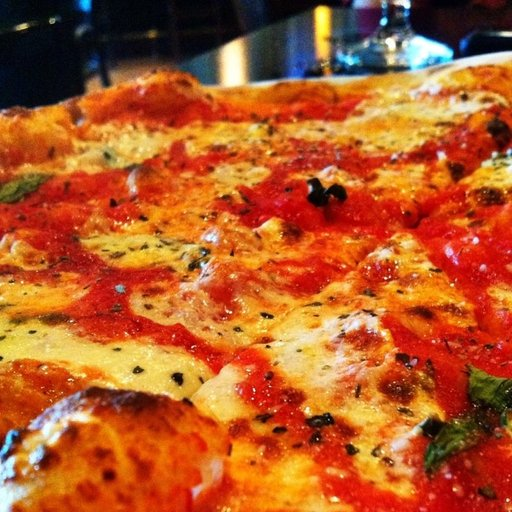

In [16]:
import random
from PIL import Image

random.seed(42)

# Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Get random iamge path
random_image_path = random.choice(image_path_list)

# Get image class from path name - the image class is the name of the directory
# where the image is stored
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can also use *matplotlib.pyplot.imshow()* but the only difference would be that we need to convert the image into a NumPy array first. 

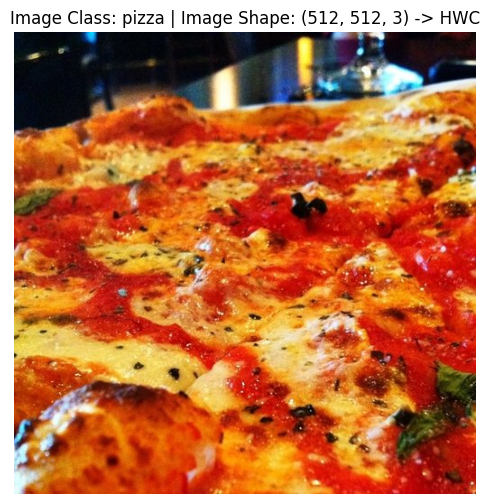

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# turning the image into a numpy array
img_as_array = np.asarray(img)

# plotting the image with matplotlib
plt.figure(figsize=(6,6))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape} -> HWC")
plt.axis(False);

Let's say that we wanted to load our image data into Pytorch - before we can start doing that we need to do the following:

1. Turn the image into tensors - numerical representation of the image
2. Turn it into a *torch.utils.data.Dataset* and subsequently a *torch.utils.data.DataLoader* - these are both *Dataset* and *DataLoader* for short.

There are many different kinds of pre-built datasets and dataset loaders for PyTorch and it all depends on the problem that is being worked on. 

1. Vision -> *torchvision.datasets*
2. Audio -> *torchaudio.datasets*
3. Text -> *torchtext.datasets*
4. Recommendations -> *torchrec.datasets*

Because we are working with a vision problem then it's pretty clear to see that we need to use *torchvision.datasets* for the data loading function + *torchvision.transforms* for preparing the data. 

Let's start importing the base libraries for these. 

In [21]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

**Transforming Data with *torchvision.transforms***

We have folders of images but before we can use them, we have to transform the into tensors. One way that we could do that is by using the *torchvision.transforms* module.

*torchvision.transforms* contain many prebuilt methods for formatting images, turning to tensors, and even manipulating them for **data augmentation** - the practice of altering the data to make it harder for the model to learn. 

To get some hands-on experience with *torchvision.transforms*, we can write a series of transform steps that can do the following: 

1. Resize the images using *transforms.Resize()* from about 512x512 to 64x64. The same shape as the images on the CNN Explainer website.

2. Flip the images randomly on the horizontal using *transforms.RandomHorizontalFlip()* - this can be considered as a form of data augmentation since we are artifically changing the image data.

3. Turn the images from a PIL image to a PyTorch tensor by *transforms.ToTensor()*

We can combine all these steps by using *torchvision.transforms.Compose()*

In [26]:
data_transform = transforms.Compose([
    # Resizing the images to 64x64
    transforms.Resize(size=(64,64)),
    # Flipping the images - p stands for probability of a flip
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor - converts all pixel values from 0-255 to 0.0 to 1.0
    transforms.ToTensor(),
])

Because we have now built a means to transform the images based on our specifications, we can now try them on different images. Let's make a function that does exactly that.

In [37]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    # Plot a series of random images from image paths -

    # will open n image paths from image_paths then transform them
    # with transform then plot them side by side

    # Args: 
    # image_paths : list - lists of target image paths
    # transform : PyTorch Transforms - the transform specifications that would be applied
    # to all images selected
    # n : int (optional) - Number of images to be plotted - defaults to 3 
    # seed : int (optional) - Random seed for the random generator

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            plt.figure(figsize=(10,10))
            # Showing original image
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size: {f.size}")
            ax[0].axis("off")

            # Transforming & plotting image
            # permute() changes the shape of the image to suit matplotlib
            # PyTorch is CHW while matplotlib is HWC
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Size: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)

<Figure size 1000x1000 with 0 Axes>

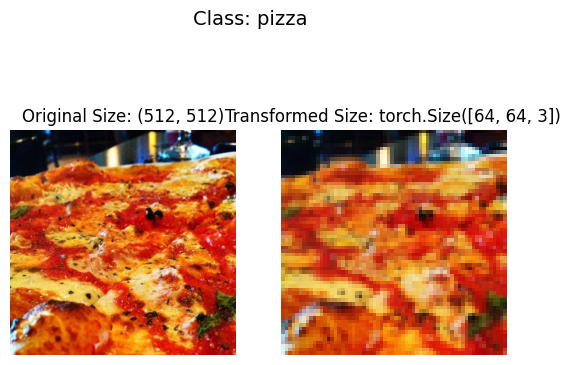

<Figure size 1000x1000 with 0 Axes>

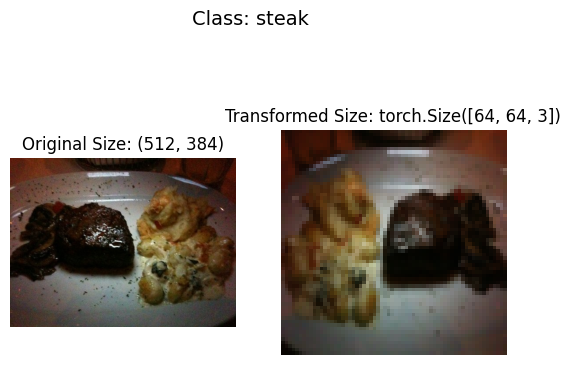

<Figure size 1000x1000 with 0 Axes>

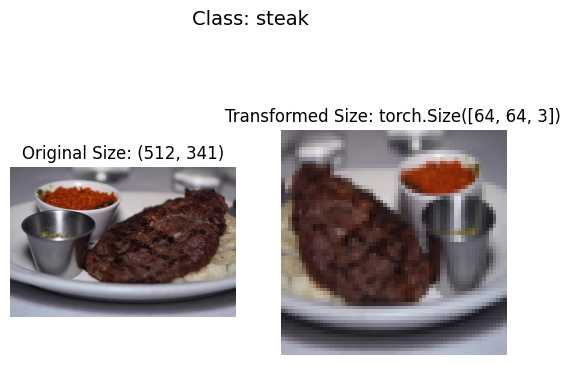

In [38]:
plot_transformed_images(image_path_list, data_transform)

We've now transformed the data that we need into PyTorch tensors with *torchvision.transforms* and at the same time we also plotted them out to visualize them! We also manipulated their size and orientation. 

it goes without saying that the larger the image means that there are more information that is retained for us to use.

For example, an image size of [256,256,3] will have 16x more pixels than an image of size [64x64x3] since 256*256*3 / 64*64*3 = 16. Simple math!

But of course, it comes at a cost. Higher resolution images and larger sizes means that there are more values to consider which means higher computational power required to use. 